# CSCI E-81 HW5 - Partners: Piyawan Chirayus and Cindy Liu

<a id='imports'></a>
[Go to Table of Contents](#toc)

In [484]:
import re
import requests  # pip install requests
from bs4 import BeautifulSoup

%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

VERBOSE = True

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cindy.liu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<a id='mpl-settings'></a>

In [ ]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
set2_colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494','#b3b3b3']

bold_colors = ['#FF0000', '#00FF00', '#FFAAAA', '#0000FF']
light_colors = ['#FFAAAA', '#AAFFAA', '#AAAAFF', '#00FF00']
cmap_light = ListedColormap(light_colors)
cmap_bold = ListedColormap(bold_colors)
dark2_cmap = ListedColormap(dark2_colors)
set2_cmap = ListedColormap(dark2_colors)
light_grey = np.array([float(248)/float(255)]*3)
shade_black = '#262626'

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 150
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 16
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
def cible_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Make a target axis at 0,0 with ticks along the axis lines
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

<a id='plot-functions'></a>

In [ ]:
# Visualization functions stolen from section notebook

def plot_2D(groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    #plt.gca().xaxis.grid(True)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.6)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def plot_3D(groups, title, elevation=15, azimuth=150):
    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=elevation, azim=azimuth)
    for name, group in groups:
        ax.scatter(group.dimension1, group.dimension2, group.dimension3, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    ax.set_zlabel('3rd Dimension' )
    ax.set_ylabel('2nd Dimension' )
    ax.set_xlabel('1st Dimension' )
    ax.set_title(title)
    legend = ax.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.show()
    
def plot_2D_withlabels(df,groups, title):
    plt.figure(figsize=(10,6))
    for name, group in groups:
        plt.scatter(group.dimension1, group.dimension2, alpha = 0.6, s=30, label=cluster_names[name], 
                    facecolor=dark2_colors[name], edgecolor=shade_black, linewidth=0.35)
    for i in range(df.shape[0]):
        plt.text(df.ix[i]['dimension1'], df.ix[i]['dimension2'], df.ix[i]['title'], alpha = 0.8, color='grey', size=9)  
    plt.ylabel('2nd Dimension' )
    plt.xlabel('1st Dimension' )
    plt.title(title)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.6, scatterpoints=1)
    rect = legend.get_frame()
    rect.set_facecolor(light_grey)
    rect.set_linewidth(0.2)
    plt.gca().grid(False)
    remove_border(top=False, right=False, left=True, bottom=True)
    plt.show()

def make_plot_frame(proj, labels, cluster, title):
    get_shape = proj.shape[1]
    dimensions = ["Dimension"+str(i) for i in range(get_shape)]
    columns = ["dimension"+str(i+1) for i in range(get_shape)]
    columns.extend(["label", "cluster", "title"])
    data = np.column_stack((proj, labels, cluster, title))
    clustergroups = pd.DataFrame(data, columns = columns)
    return clustergroups

<a id='toc'></a>

## Table of Contents
- [Loading data](#loading-data)
- [Data processing](#data-processing)
- [Stemming](#stemming)
- [Feature extraction using TF-IDF](#tf-idf)
- [MDS](#mds)
- [K-means clustering](#k-means)
- [Cluster visualization](#visual-1)
- [t-distributed SNE](#td-sne)
- [Exploratory work](#exploratory)

<a id='loading-data'></a>
[Back to Table of Contents](#toc)

## Loading data

Loading the reference data provided with this homework:

In [493]:
ref = pd.read_table('Shakespeare_characters.txt', header=0, encoding='latin-1')
del ref['Unnamed: 1']
ref = ref.set_value((ref.Speaker == 'Lafew').argmax(), 'Speaker', 'Lafeu')
ref.Speaker = ref.Speaker.str.lower()  # for cross-referencing compatibility with names in the play texts
ref.head()

,Speaker,Gender,NumLines,Play,TopVillain,Fools
0,hamlet,Male,1506,Hamlet,NaN,NaN
1,iago,Male,1088,Othello,yes,NaN
2,king henry,Male,1031,Henry V,NaN,NaN
3,othello,Male,880,Othello,NaN,NaN
4,timon,Male,850,Timon of Athens,NaN,NaN


Getting the texts of all the plays by scraping the "Entire play in one page" pages:

In [492]:
BASE_URL = 'http://shakespeare.mit.edu/'

# Get main page
r = requests.get(BASE_URL)
assert(r.status_code == 200)

# Soupify main page and get table element
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find_all('table')[1]

# Scrape play titles from table element
titles = {}  # dict of plays and play data
num_titles = 0
if not VERBOSE:
    print('Getting documents', end='')
for link in table.find_all('a'):
    # Skip poetry
    if 'Poetry' not in link.get('href'):
        if '\n' in link.string:
            link.string = link.string.replace('\n', ' ').strip()
        href = link.get('href').replace('index', 'full')
        # Taking advantage of their URL naming conventions
        send_url = BASE_URL + href
        if VERBOSE:
            print('Getting {} from {}'.format(link.string, send_url))
        else:
            print('.', end='')
        num_titles += 1
        # Get text of each play and add to dict of plays
        r = requests.get(send_url)
        assert(r.status_code == 200)
        # `titles` dict structure:
        titles[link.string] = {
            'href': href,
            'soup': BeautifulSoup(r.content, 'html.parser')
        }
print('Done! Retrieved {} documents.'.format(num_titles))

Getting All's Well That Ends Well from http://shakespeare.mit.edu/allswell/full.html
Getting As You Like It from http://shakespeare.mit.edu/asyoulikeit/full.html
Getting The Comedy of Errors from http://shakespeare.mit.edu/comedy_errors/full.html
Getting Cymbeline from http://shakespeare.mit.edu/cymbeline/full.html
Getting Love's Labours Lost from http://shakespeare.mit.edu/lll/full.html
Getting Measure for Measure from http://shakespeare.mit.edu/measure/full.html
Getting The Merry Wives of Windsor from http://shakespeare.mit.edu/merry_wives/full.html
Getting The Merchant of Venice from http://shakespeare.mit.edu/merchant/full.html
Getting A Midsummer Night's Dream from http://shakespeare.mit.edu/midsummer/full.html
Getting Much Ado About Nothing from http://shakespeare.mit.edu/much_ado/full.html
Getting Pericles, Prince of Tyre from http://shakespeare.mit.edu/pericles/full.html
Getting Taming of the Shrew from http://shakespeare.mit.edu/taming_shrew/full.html
Getting The Tempest from 

<a id='data-processing'></a>
[Back to Table of Contents](#toc)

## Processing raw documents into data frame

In [462]:
COLUMN_NAMES = ['Title','Act','Scene','Speaker','Words']


# Given the data in the parameters, decides how to add the data to the data frame.
def add_data(df, title, act, scene, speaker, words):
    # Do we already have an entry for this speaker?
    if speaker in df.Speaker.values:
        # Get the row index of this speaker and add the new words to that speaker's existing words
        indices = list(df[df.Title == title][df.Act == act][df.Scene == scene][df.Speaker == speaker].index)
        if len(indices) == 1:
            index = indices[0]
            df.set_value(index, 'Words', df.Words[index] + ' ' + words)
            return df
        # In case of weird errors, but there should never be more than one row fitting above criteria
        elif len(indices) > 1:
            print(title, act, scene, speaker, indices)
            return df
    # If this is a totally new speaker, make a new row entry in the data frame for him/her
    new_row = pd.DataFrame([[title, act, scene, speaker, words]], columns=COLUMN_NAMES)
    df = df.append(new_row, ignore_index=True)
    return df


data = pd.DataFrame([], columns=COLUMN_NAMES)
num_processed = 0
if not VERBOSE:
    print('Processing documents', end='')

# For each play, iterate through each line of the play's html text sequentially,
#  tracking which act, scene, and speaker we're on. Whenever a new speaker
#  or a new scene/act arrives, take the words we've gathered for the last speaker
#  and add them to the data frame.
# The resulting table will contain 1 row for each unique combination of play,
#  act, scene, and speaker. Thus the words for each speaker are grouped by scene.
#        ** NB: This script ONLY scrapes character speeches - if
#        **     prologue material exists without a speaker specified
#        **     (i.e., "narrator" text), this script will ignore it.
for title in titles:
    if VERBOSE:
        print(title)
    else:
        print('.', end='')
    # Skip to the first act - which is not always ACT I but sometimes PROLOGUE or even None
    act = titles[title]['soup'].find('h3')
    scene = speaker = words = ''
    # The rest of this is essentially just a big nested switch statement.
    if act.string[:3] != 'ACT':
        scene = act.string.split('.')[0]
        act.string = 'None'
    for elem in act.next_elements:
        if elem.name == 'h3':
            if words:
                data = add_data(data, title, act.string, scene, speaker, words)
                words = ''
            if elem.string[:3] == 'ACT':
                act = elem
            else:
                scene = elem.string.split('.')[0]
        if elem.name == 'a':
            if elem.attrs['name'][:6] == 'speech':
                if words:
                    data = add_data(data, title, act.string, scene, speaker, words)
                    words = ''
                speaker = elem.string.lower()
            else:
                if words:
                    words += ' ' + elem.string.strip()
                else:
                    words += elem.string.strip()
    num_processed += 1
print('Done! Processed {} documents.'.format(num_processed))

Processing documents.

/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


....................................Done! Processed 37 documents.


Here we're removing all punctuation to make things simpler. We thought about leaving apostrophes in, because Shakespeare had a known penchant for using apostrophes to stylistically shorten words, but this resulted in a feature that consisted solely of a single apostrophe, so we decided to omit them in the end.

We are also making all the character names lowercase because it's inconsistent across plays (some of them would have "Hamlet" while others would have "HAMLET" and so on). We made all the character names in the reference data frame lowercase as well, so that they would actually be able to align.

In [562]:
data.Words = data.Words.str.replace("[^a-zA-Z]", " ")
data.Words = data.Words.str.lower()
print('DataFrame dimensions:', data.shape)
print('Reference dimensions:', ref.shape)
data.head(15)

DataFrame dimensions: (3974, 5)
Reference dimensions: (1533, 6)


,Title,Act,Scene,Speaker,Words
0,Coriolanus,ACT I,SCENE I,first citizen,before we proceed any further hear me speak ...
1,Coriolanus,ACT I,SCENE I,all,speak speak resolved resolved we know t w...
2,Coriolanus,ACT I,SCENE I,second citizen,one word good citizens would you proceed esp...
3,Coriolanus,ACT I,SCENE I,menenius,what work s my countrymen in hand where go ...
4,Coriolanus,ACT I,SCENE I,marcius,thanks what s the matter you dissentious rog...
5,Coriolanus,ACT I,SCENE I,messenger,where s caius marcius the news is sir the v...
6,Coriolanus,ACT I,SCENE I,first senator,marcius tis true that you have lately told u...
7,Coriolanus,ACT I,SCENE I,cominius,you have fought together it is your former pr...
8,Coriolanus,ACT I,SCENE I,titus,no caius marcius i ll lean upon one crutch a...
9,Coriolanus,ACT I,SCENE I,sicinius,was ever man so proud as is this marcius when...


<a id='stemming'></a>
[Back to Table of Contents](#toc)

## Stemming

We're using the standard Porter stemmer here, and we decided to leave open the option of using no stemming as well.

In [502]:
porter = PorterStemmer()

def tokenizer_porter(text):
    #for word in text.split():
    #    print(word, porter.stem(word))
    return [porter.stem(word) for word in text.split()]

def tokenizer_vanilla(text):
    return [word for word in text.split()]

print(tokenizer_porter('It was a bright cold day in April and the clocks were striking thirteen'))
print(tokenizer_vanilla('It was a bright cold day in April and the clocks were striking thirteen'))

['It', 'wa', 'a', 'bright', 'cold', 'day', 'in', 'April', 'and', 'the', 'clock', 'were', 'strike', 'thirteen']
['It', 'was', 'a', 'bright', 'cold', 'day', 'in', 'April', 'and', 'the', 'clocks', 'were', 'striking', 'thirteen']


<a id='tf-idf'></a>
[Back to Table of Contents](#toc)

## Feature extraction using TF-IDF

All very standard using the default values for the most part.

In [485]:
all_stopwords = stopwords.words('english')
vectorizer = TfidfVectorizer(tokenizer = tokenizer_vanilla,
                             stop_words=all_stopwords,
                             use_idf=False,
                             max_features = 100,ngram_range=(1,1))
train_data_features = vectorizer.fit_transform(data.Words.values)
train_data_features = train_data_features.A
vocab = vectorizer.get_feature_names()

In [490]:
df = pd.DataFrame(data=train_data_features,columns=vocab)
print(df.shape)
df.head()

(3974, 100)


,','tis,art,away,ay,bear,better,blood,brother,call,...,true,two,upon,us,way,well,whose,world,would,yet
0,0.000000,0.0,0.000000,0.000000,0.061663,0.061663,0.0,0.000000,0.0,0.000000,...,0.061663,0.0,0.000000,0.678289,0.000000,0.308313,0.000000,0.000000,0.184988,0.123325
1,0.000000,0.0,0.000000,0.516398,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.267261,0.000000,0.000000,0.000000,0.267261,0.000000
3,0.211604,0.0,0.070535,0.000000,0.000000,0.000000,0.0,0.141069,0.0,0.000000,...,0.070535,0.0,0.070535,0.000000,0.141069,0.282138,0.070535,0.000000,0.000000,0.141069
4,0.000000,0.0,0.082761,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.082761,...,0.000000,0.0,0.331042,0.000000,0.000000,0.082761,0.082761,0.082761,0.496564,0.000000


<a id='mds'></a>
[Back to Table of Contents](#toc)

## MDS

In [491]:
CS_dist = 1 - cosine_similarity(train_data_features)
Euclid_dist = euclidean_distances(train_data_features)
print(Euclid_dist.shape, CS_dist.shape)

(3974, 3974) (3974, 3974)


In [504]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=99)
text_MDS = mds.fit_transform(CS_dist)  # shape (n_components, n_samples)
text_MDS.shape

(3974, 2)

<a id='k-means'></a>
[Back to Table of Contents](#toc)

## K-means clustering

Insert text here

In [532]:
cluster_names = {0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5', 5: 'C6'}
MAX_CLUSTERS = 5
kmeans = KMeans(init='k-means++', n_clusters=MAX_CLUSTERS, n_init=10)
kmeans.fit(train_data_features)
df['KM_cluster'] = kmeans.predict(train_data_features)
df['KM_cluster'].replace(cluster_names, inplace=True)

In [533]:
print("\nTotal number of clusters and composition: ")
print (df['KM_cluster'].value_counts()[::-1])
print("\nSilhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_data_features, kmeans.labels_, sample_size=1000))


Total number of clusters and composition: 
C4     407
C2     483
C5     853
C3     878
C1    1353
Name: KM_cluster, dtype: int64

Silhouette Coefficient: 0.084


<a id='visual-1'></a>
[Back to Table of Contents](#toc)

## Cluster visualization

In [513]:
df.loc[:,'SpeakerIndex'] = data.index.values
df.head()

,','tis,art,away,ay,bear,better,blood,brother,call,...,upon,us,way,well,whose,world,would,yet,KM_cluster,SpeakerIndex
0,0.000000,0.0,0.000000,0.000000,0.061663,0.061663,0.0,0.000000,0.0,0.000000,...,0.000000,0.678289,0.000000,0.308313,0.000000,0.000000,0.184988,0.123325,C1,0
1,0.000000,0.0,0.000000,0.516398,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,C1,1
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.267261,0.000000,0.000000,0.000000,0.267261,0.000000,C1,2
3,0.211604,0.0,0.070535,0.000000,0.000000,0.000000,0.0,0.141069,0.0,0.000000,...,0.070535,0.000000,0.141069,0.282138,0.070535,0.000000,0.000000,0.141069,C1,3
4,0.000000,0.0,0.082761,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.082761,...,0.331042,0.000000,0.000000,0.082761,0.082761,0.082761,0.496564,0.000000,C1,4


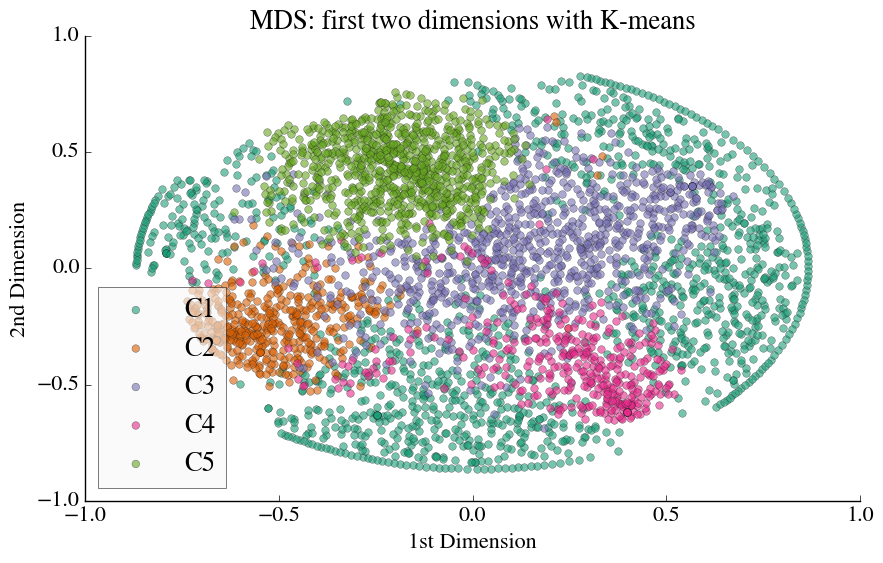

In [534]:
dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']

df1 = make_plot_frame(text_MDS, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"SpeakerIndex"])
clusterGroups = df1.groupby('label')

# Plot the features with MDS  
plot_2D(clusterGroups, 'MDS: first two dimensions with K-means')  

<a id='td-sne'></a>
[Back to Table of Contents](#toc)

## t-distributed Stochastic Neighbor Embedding

In [ ]:
#t-Distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(train_data_features)
X_embedded = TSNE(n_components=3, perplexity=40, verbose=0).fit_transform(X_reduced)

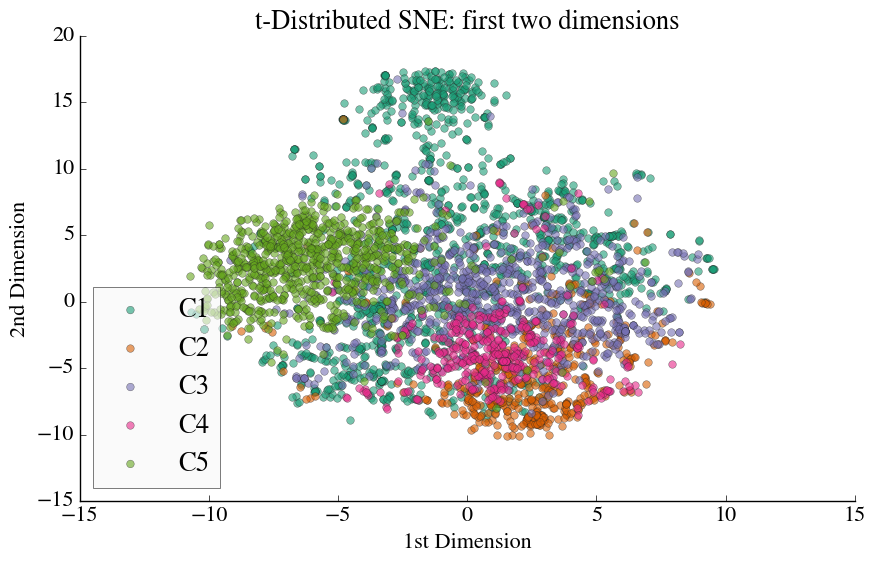

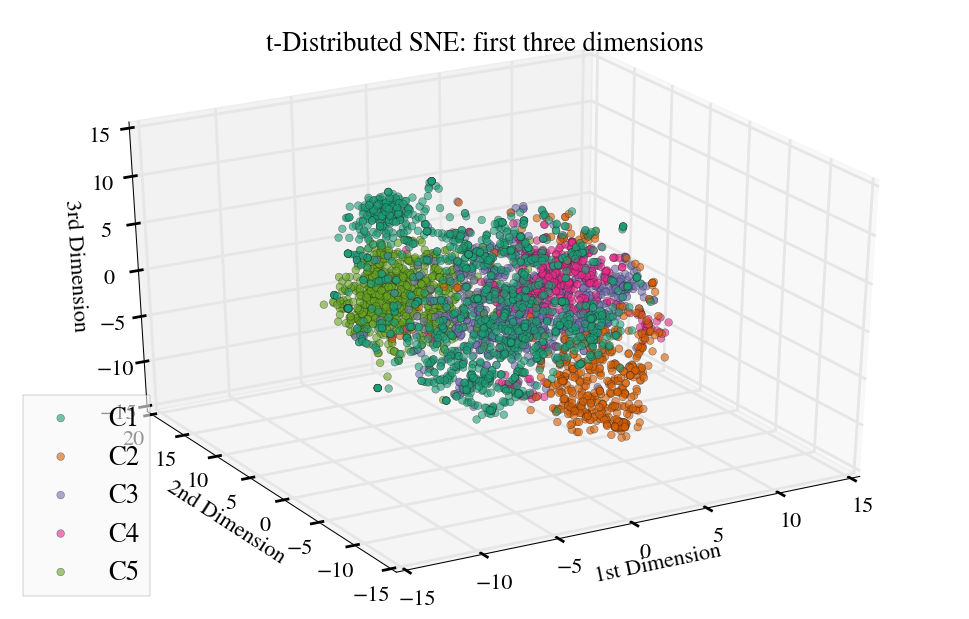

In [559]:
df2 = make_plot_frame(X_embedded, kmeans.labels_, df.loc[:,"KM_cluster"],df.loc[:,"SpeakerIndex"])
clusterGroups = df2.groupby('label')

# Plot the features with t-SNE  
plot_2D(clusterGroups, 't-Distributed SNE: first two dimensions')
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 30, 240)

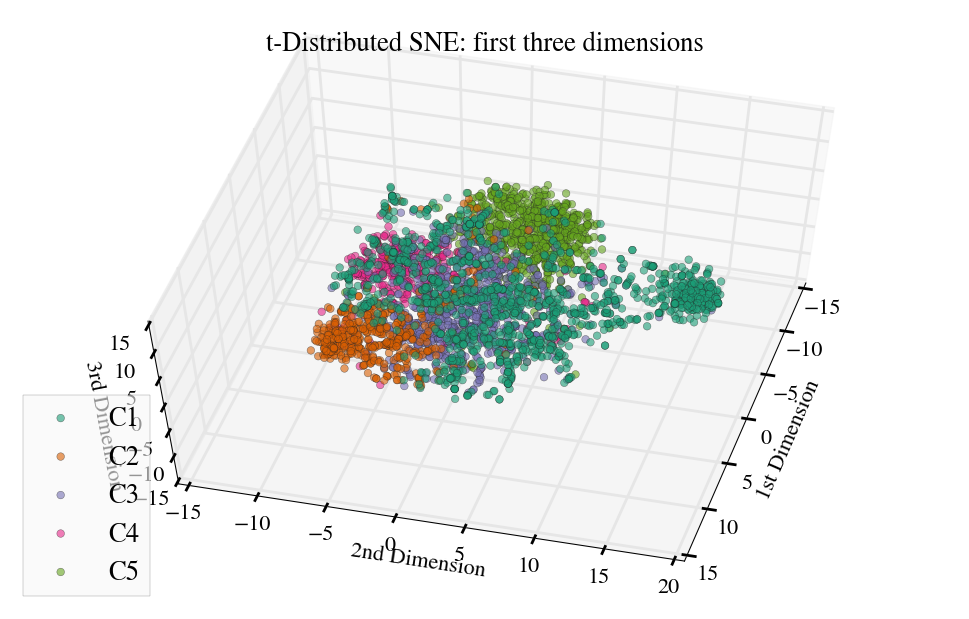

In [557]:
plot_3D(clusterGroups, 't-Distributed SNE: first three dimensions', 60, 15)

In [357]:
missing_from_mine = []
missing_from_ref = []
have = data['Speaker'].unique()
check = ref['Speaker'].unique()
check = [x.lower() for x in check]
for x in check:
    if x not in have:
        missing_from_mine.append(x)
for x in have:
    if x not in check:
        missing_from_ref.append(x)
print('Missing from mine:', len(missing_from_mine))
print('Missing from ref:', len(missing_from_ref))

Missing from mine: 296
Missing from ref: 178


<a id='exploratory'></a>
[Back to Main Table of Contents](#toc)

# ================ Exploratory Work ================

<a id='exp-toc'></a>

## Table of Contents
- []()

### Ideas for exploration
1. Extract features consistently solely of characters' usage of "I", "me", "mine" vs. "you", "yours" and other subject/object pronouns (or just pronouns in general) to assess how self-centered each character is
- Extract features based on punctuation - could maybe see if some characters are more "shouty" than others, whether some ask more/mostly questions, whether some tend to speak in run-on sentences?
- Include only the speech of the main character of each play and see if that alone can predict the genre
- Include only the speech of female characters and see whether any interesting patterns come out of that
- See if you can identify which characters are married/have children/are in love/etc.
- Instead of grouping text by each speaker in a scene, group by all the scenes for a single speaker and see if patterns emerge for a single character as the play progresses from beginning to end
- Sentiment analysis (probably don't have time for this, but it'd be cool)
  - OR could do a poor man's sentiment analysis and try to map characters in relation to other characters based on how often they say other characters' names?